# Design of Experiments (DOE)

In [ ]:
import pandas as pd
import matplotlib.pyplot as plt
import numpy as np
import seaborn as sns

import itertools
from itertools import product

import oapackage

import statsmodels.api as sm
from statsmodels.formula.api import ols

from sklearn.linear_model import LinearRegression
from sklearn.metrics import mean_squared_error
from sklearn.preprocessing import PolynomialFeatures
from sklearn.model_selection import train_test_split

%matplotlib inline

## Full Factorial Design

In [75]:
def generate_full_factorial_design(factor_levels):
    factor_combinations = list(itertools.product(*factor_levels))
    trials = len(factor_combinations)
    full_factorial_design = []

    for i in range(trials):
        row = [i + 1]
        for j in range(len(factor_levels)):
            row.append(factor_combinations[i][j])
        full_factorial_design.append(row)

    return full_factorial_design

def create_full_factorial_design_table(full_factorial_design):
    headers = ["Trial", "V (mm/min)", "w (rpm)", "PD (mm)"]
    df = pd.DataFrame(full_factorial_design, columns=headers)
    return df

# Define the factor levels
factor_levels = [
    [1300, 1600, 2000],  # Factor A levels
    [3500, 4250, 5000],  # Factor B levels
    [2.6, 2.65, 2.7]  # Factor C levels
]

# Generate the full factorial design
full_factorial_design = generate_full_factorial_design(factor_levels)

# Create and display the full factorial design table
full_factorial_design_table = create_full_factorial_design_table(full_factorial_design)
print(full_factorial_design_table.to_string(index=False))


 Trial  V (mm/min)  w (rpm)  PD (mm)
     1        1300     3500     2.60
     2        1300     3500     2.65
     3        1300     3500     2.70
     4        1300     4250     2.60
     5        1300     4250     2.65
     6        1300     4250     2.70
     7        1300     5000     2.60
     8        1300     5000     2.65
     9        1300     5000     2.70
    10        1600     3500     2.60
    11        1600     3500     2.65
    12        1600     3500     2.70
    13        1600     4250     2.60
    14        1600     4250     2.65
    15        1600     4250     2.70
    16        1600     5000     2.60
    17        1600     5000     2.65
    18        1600     5000     2.70
    19        2000     3500     2.60
    20        2000     3500     2.65
    21        2000     3500     2.70
    22        2000     4250     2.60
    23        2000     4250     2.65
    24        2000     4250     2.70
    25        2000     5000     2.60
    26        2000     5000     2.65
 

## Taguchi Method

In [94]:
run_size = 32
number_of_factors = 7
factor_levels = 2
strength = 2
nkeep = 24  # Number of designs to keep at each stage

arrayclass = oapackage.arraydata_t(factor_levels, run_size, strength, number_of_factors)
print("In this example we generate orthogonal arrays in the class: %s" % arrayclass)

In this example we generate orthogonal arrays in the class: arrayclass: N 32, k 7, strength 2, s {2,2,2,2,2,2,2}, order 0


In [95]:
arraylist = [arrayclass.create_root()]

# %% Extend arrays and filter based on D-efficiency
options = oapackage.OAextend()
options.setAlgorithmAuto(arrayclass)

for extension_column in range(strength + 1, number_of_factors + 1):
    print("extend %d arrays with %d columns with a single column" % (len(arraylist), arraylist[0].n_columns))
    arraylist_extensions = oapackage.extend_arraylist(arraylist, arrayclass, options)

    # Select the best arrays based on the D-efficiency
    dd = np.array([a.Defficiency() for a in arraylist_extensions])
    ind = np.argsort(dd)[::-1][0:nkeep]
    selection = [arraylist_extensions[ii] for ii in ind]
    dd = dd[ind]
    print(
        "  generated %d arrays, selected %d arrays with D-efficiency %.4f to %.4f"
        % (len(arraylist_extensions), len(ind), dd.min(), dd.max())
    )

    arraylist = selection

extend 1 arrays with 2 columns with a single column
  generated 5 arrays, selected 5 arrays with D-efficiency 0.0000 to 1.0000
extend 5 arrays with 3 columns with a single column
  generated 19 arrays, selected 19 arrays with D-efficiency 0.0000 to 1.0000
extend 19 arrays with 4 columns with a single column
  generated 491 arrays, selected 24 arrays with D-efficiency 0.9183 to 1.0000
extend 24 arrays with 5 columns with a single column
  generated 2475 arrays, selected 24 arrays with D-efficiency 0.9196 to 1.0000
extend 24 arrays with 6 columns with a single column
  generated 94 arrays, selected 24 arrays with D-efficiency 0.7844 to 0.8360


In [96]:
selected_array = selection[0]
print(
    "Generated a design in OA(%d, %d, 2^%d) with D-efficiency %.4f"
    % (selected_array.n_rows, arrayclass.strength, selected_array.n_columns, dd[0])
)
print("The array is (in transposed form):\n")
selected_array.transposed().showarraycompact()

Generated a design in OA(32, 2, 2^7) with D-efficiency 0.8360
The array is (in transposed form):

00000000000000001111111111111111
00000000111111110000000011111111
00000111000111110001111100000111
00011001011001110110011100011001
00101010101010111010101100101010
01001011010110011101000101101001
01110010001101010111001010100011


In [109]:
features = ["V (mm/min)", "w (rpm)", "PD (mm)"]
factor_levels = [
    [1300, 1600, 2000],  
    [3500, 4250, 5000], 
    [2.6, 2.65, 2.7]  
]

factor_combinations = list(product(*factor_levels))
table_data = [[i + 1] + list(vals) for i, vals in enumerate(factor_combinations)]

df = pd.DataFrame(table_data, columns=["trial"] + features)
filtered_df = df[df['trial'].isin([1, 5, 9, 11, 15, 16, 21, 23, 26])]
filtered_df = filtered_df.reset_index(drop=True)
filtered_df['trial'] = range(1, len(filtered_df) + 1)
print(filtered_df.to_string(index=False))


 trial  V (mm/min)  w (rpm)  PD (mm)
     1        1300     3500     2.60
     2        1300     4250     2.65
     3        1300     5000     2.70
     4        1600     3500     2.65
     5        1600     4250     2.70
     6        1600     5000     2.60
     7        2000     3500     2.70
     8        2000     4250     2.65
     9        2000     5000     2.65


### Experimental Results

In [112]:
df_fsw = pd.read_csv(".\\data\\paper4.csv")

In [113]:
cols = ["OL (mm)", "DAF (N)", "FF (N)"]
X = df_fsw.drop(cols, axis=1)  # Features
FF = df_fsw["FF (N)"]  # Target variable

In [114]:
X.head(10)

,V (mm/min),w (rpm),PD (mm)
0,1300,3500,2.60
1,1300,4250,2.65
2,1300,5000,2.70
3,1600,3500,2.65
4,1600,4250,2.70
5,1600,5000,2.60
6,2000,3500,2.70
7,2000,4250,2.60
8,2000,5000,2.65
9,1300,5000,2.64


In [115]:
df_fsw.head(10)

,V (mm/min),w (rpm),PD (mm),OL (mm),DAF (N),FF (N)
0,1300,3500,2.60,11.8,2930,7661
1,1300,4250,2.65,15.6,3630,7261
2,1300,5000,2.70,18.8,4040,6063
3,1600,3500,2.65,18.9,3950,7373
4,1600,4250,2.70,11.6,3860,6374
5,1600,5000,2.60,15.6,2930,5848
6,2000,3500,2.70,15.6,4700,7346
7,2000,4250,2.60,18.7,3650,6954
8,2000,5000,2.65,11.1,3590,5297
9,1300,5000,2.64,18.7,3630,6612


In [119]:
# Perform ANOVA analysis
model = ols('Q("FF (N)") ~ Q("V (mm/min)") + Q("w (rpm)") + Q("PD (mm)") + Q("OL (mm)") + Q("DAF (N)")', data=df_fsw).fit()
anova_table = sm.stats.anova_lm(model)

# Print the ANOVA table
print(anova_table)

                  df        sum_sq       mean_sq          F    PR(>F)
Q("V (mm/min)")  1.0  1.219532e+06  1.219532e+06   3.577336  0.100471
Q("w (rpm)")     1.0  4.913040e+06  4.913040e+06  14.411759  0.006747
Q("PD (mm)")     1.0  2.075048e+05  2.075048e+05   0.608688  0.460844
Q("OL (mm)")     1.0  6.724977e+04  6.724977e+04   0.197268  0.670341
Q("DAF (N)")     1.0  2.658600e+05  2.658600e+05   0.779865  0.406487
Residual         7.0  2.386335e+06  3.409049e+05        NaN       NaN


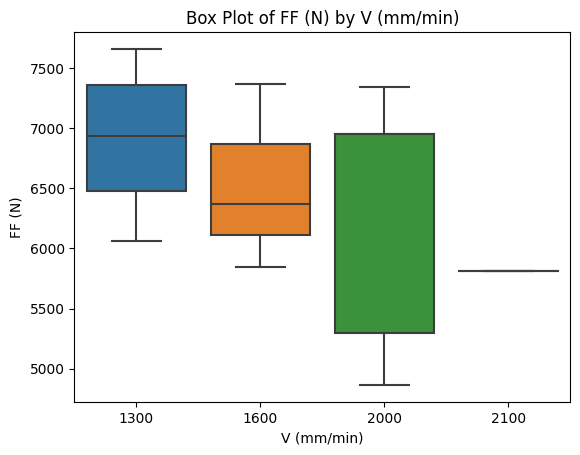

In [121]:
# Extract the group means
group_means = df_fsw.groupby(["V (mm/min)", "w (rpm)", "PD (mm)", "OL (mm)", "DAF (N)"])["FF (N)"].mean().reset_index()

# Visualize the group means using box plots
sns.boxplot(data=group_means, x="V (mm/min)", y="FF (N)")
plt.xlabel("V (mm/min)")
plt.ylabel("FF (N)")
plt.title("Box Plot of FF (N) by V (mm/min)")
plt.show()

#### Fit a Polynomial Distribution Formula

In [122]:
# Fit a polynomial regression model
X = df_fsw[['V (mm/min)', 'w (rpm)', 'PD (mm)', 'OL (mm)', 'DAF (N)']]
X = sm.add_constant(X)
y = df_fsw['FF (N)']

model = sm.OLS(y, X)
results = model.fit()

# Print the model summary
print(results.summary())

                            OLS Regression Results                            
Dep. Variable:                 FF (N)   R-squared:                       0.737
Model:                            OLS   Adj. R-squared:                  0.548
Method:                 Least Squares   F-statistic:                     3.915
Date:                Sun, 11 Jun 2023   Prob (F-statistic):             0.0517
Time:                        17:09:33   Log-Likelihood:                -97.228
No. Observations:                  13   AIC:                             206.5
Df Residuals:                       7   BIC:                             209.8
Df Model:                           5                                         
Covariance Type:            nonrobust                                         
                 coef    std err          t      P>|t|      [0.025      0.975]
------------------------------------------------------------------------------
const       4.236e+04   4.53e+04      0.935      0.3

C:\Users\tohid\anaconda3\envs\tf\lib\site-packages\scipy\stats\_stats_py.py:1736: UserWarning: kurtosistest only valid for n>=20 ... continuing anyway, n=13
  warnings.warn("kurtosistest only valid for n>=20 ... continuing "


#### Fitting a Linear Regression model and minimize RMSE

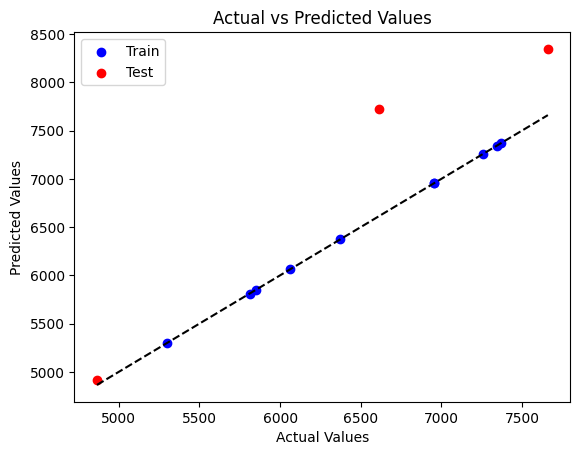

Train RMSE: 0.00
Test RMSE: 756.06


In [124]:
# Split the dataset into training and testing sets
X = df_fsw[['V (mm/min)', 'w (rpm)', 'PD (mm)', 'OL (mm)', 'DAF (N)']]
y = df_fsw['FF (N)']
X_train, X_test, y_train, y_test = train_test_split(X, y, test_size=0.2, random_state=42)

# Fit a polynomial regression model
degree = 2  # Degree of the polynomial
poly_features = PolynomialFeatures(degree=degree)
X_train_poly = poly_features.fit_transform(X_train)
X_test_poly = poly_features.transform(X_test)

model = LinearRegression()
model.fit(X_train_poly, y_train)

# Predict using the model
y_train_pred = model.predict(X_train_poly)
y_test_pred = model.predict(X_test_poly)

# Calculate the RMSE
train_rmse = np.sqrt(mean_squared_error(y_train, y_train_pred))
test_rmse = np.sqrt(mean_squared_error(y_test, y_test_pred))

# Plot the predicted values versus the actual values
plt.scatter(y_train, y_train_pred, color='blue', label='Train')
plt.scatter(y_test, y_test_pred, color='red', label='Test')
plt.plot([min(y), max(y)], [min(y), max(y)], color='black', linestyle='--')
plt.xlabel('Actual Values')
plt.ylabel('Predicted Values')
plt.title('Actual vs Predicted Values')
plt.legend()
plt.show()

# Print the RMSE
print(f"Train RMSE: {train_rmse:.2f}")
print(f"Test RMSE: {test_rmse:.2f}")